In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

from skimage.filters import threshold_local
from PIL import Image

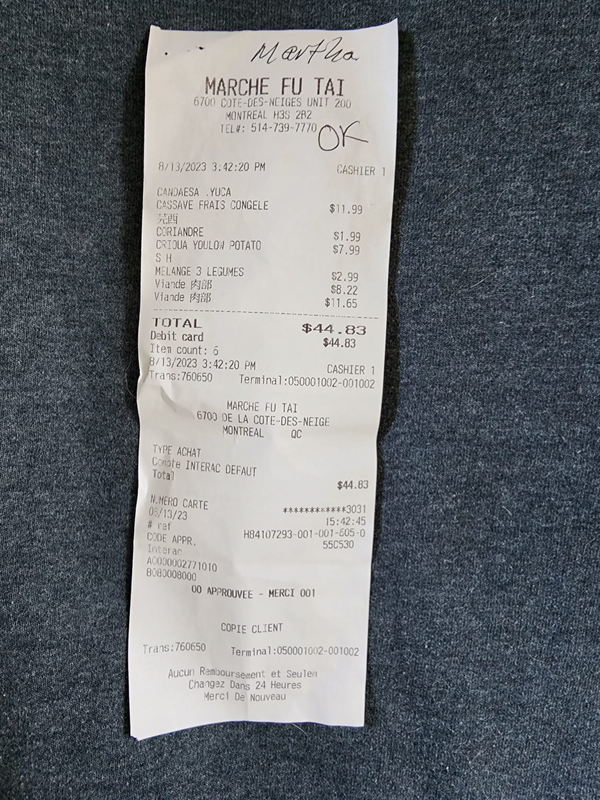

In [3]:
# Sample file out of the dataset
file_name = '../resources/fu2.jpeg'
img = Image.open(file_name)
img.thumbnail((800,800), Image.LANCZOS)
img

In [4]:
def opencv_resize(image, ratio):
    width = int(image.shape[1] * ratio)
    height = int(image.shape[0] * ratio)
    dim = (width, height)
    return cv2.resize(image, dim, interpolation = cv2.INTER_AREA)

In [5]:
def plot_rgb(image):
    plt.figure(figsize=(16,10))
    return plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

In [6]:
def plot_gray(image):
    plt.figure(figsize=(16,10))
    return plt.imshow(image, cmap='Greys_r')

In [7]:
image = cv2.imread(file_name)
# Downscale image as finding receipt contour is more efficient on a small image
resize_ratio = 500 / image.shape[0]
original = image.copy()
image = opencv_resize(image, resize_ratio)

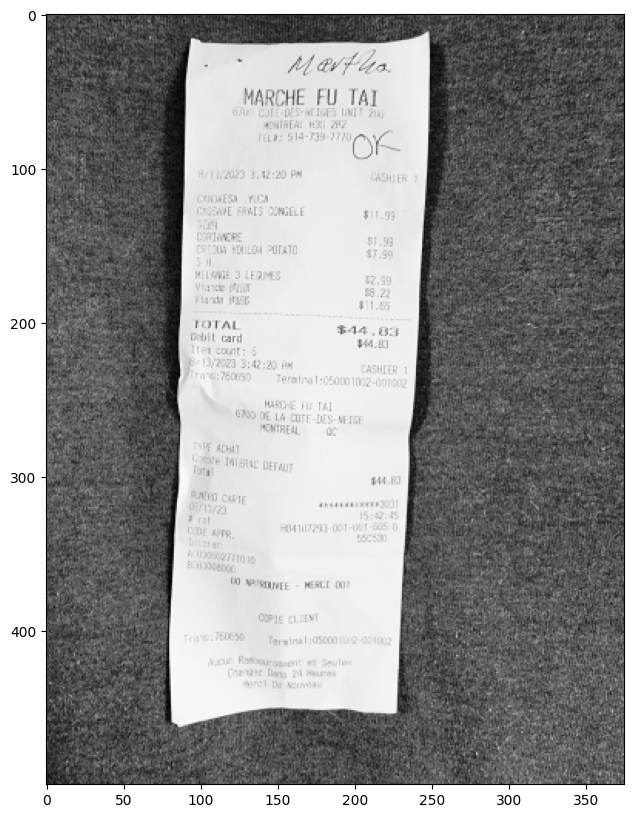

In [8]:
# Convert to grayscale for further processing
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
plot_gray(gray)

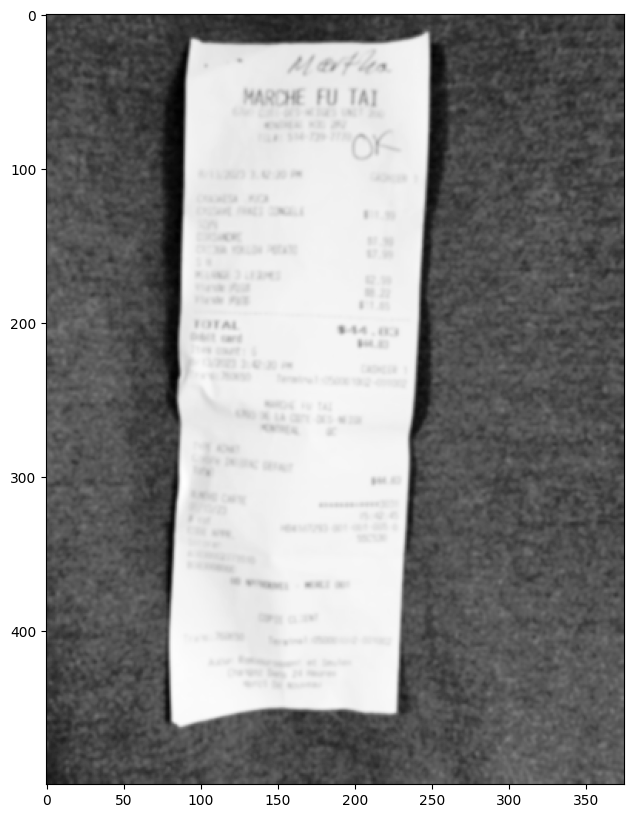

In [9]:
# Get rid of noise with Gaussian Blur filter
blurred = cv2.GaussianBlur(gray, (5, 5), 0)
plot_gray(blurred)

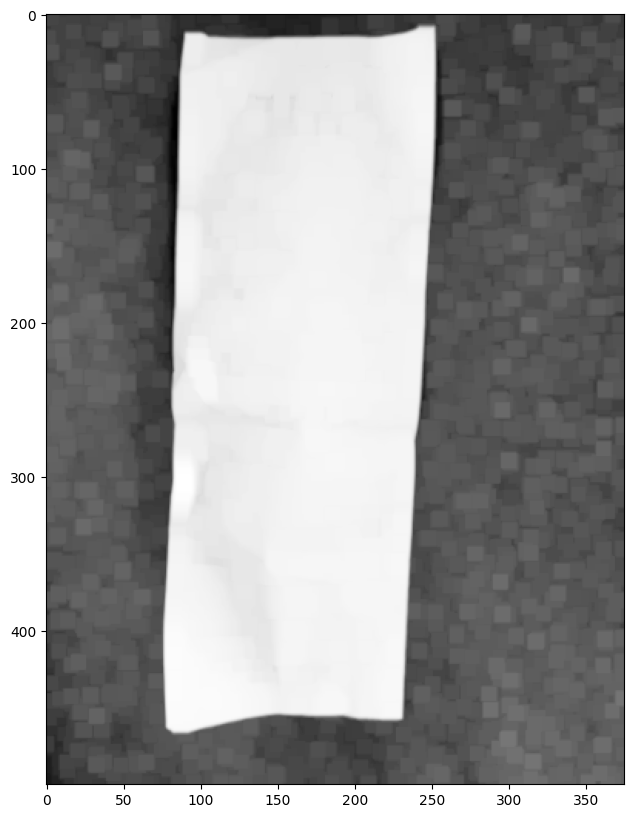

In [10]:
# Detect white regions
rectKernel = cv2.getStructuringElement(cv2.MORPH_RECT, (9,9 ))
dilated = cv2.dilate(blurred, rectKernel)
plot_gray(dilated)

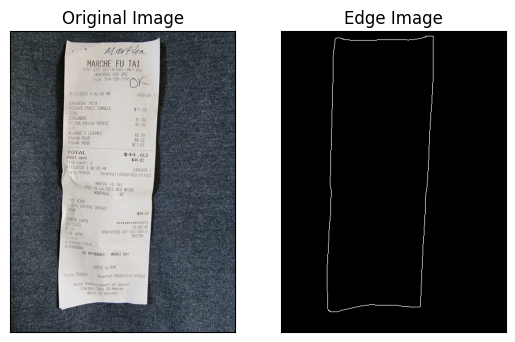

In [11]:
edged = cv2.Canny(dilated, 100, 200, apertureSize=3)
plt.subplot(121),plt.imshow(img,cmap = 'gray')
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(edged,cmap = 'gray')
plt.title('Edge Image'), plt.xticks([]), plt.yticks([])
plt.show()

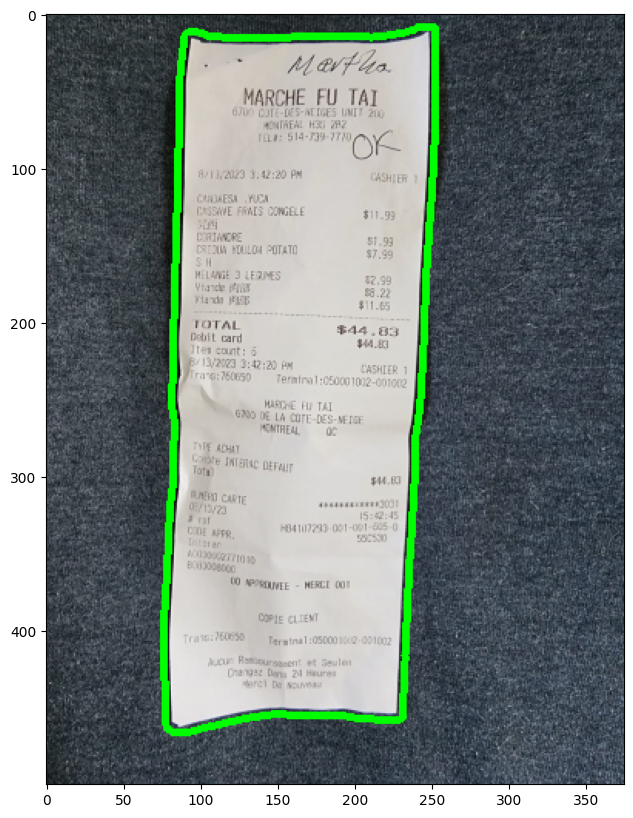

In [12]:
# Detect all contours in Canny-edged image
contours, hierarchy = cv2.findContours(edged, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
image_with_contours = cv2.drawContours(image.copy(), contours, -1, (0,255,0), 3)
plot_rgb(image_with_contours)

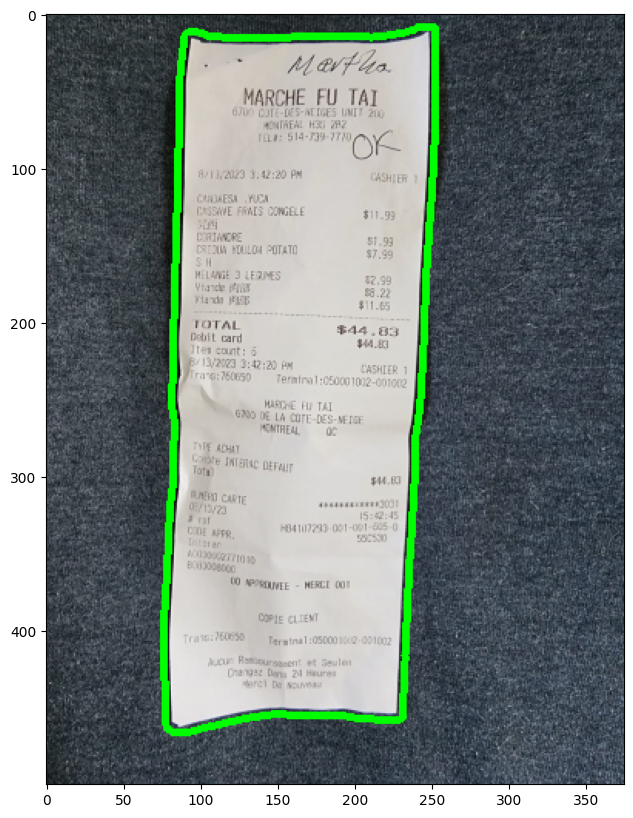

In [13]:
# Get 10 largest contours
largest_contours = sorted(contours, key = cv2.contourArea, reverse = True)[:10]
image_with_largest_contours = cv2.drawContours(image.copy(), largest_contours, -1, (0,255,0), 3)
plot_rgb(image_with_largest_contours)

In [14]:
# approximate the contour by a more primitive polygon shape
def approximate_contour(contour):
    peri = cv2.arcLength(contour, True)
    return cv2.approxPolyDP(contour, 0.032 * peri, True)

In [15]:
def get_receipt_contour(contours):    
    # loop over the contours
    for c in contours:
        approx = approximate_contour(c)
        # if our approximated contour has four points, we can assume it is receipt's rectangle
        if len(approx) == 4:
            return approx

In [16]:
get_receipt_contour(largest_contours)


array([[[252,   8]],

       [[ 89,  14]],

       [[ 81, 466]],

       [[231, 457]]], dtype=int32)

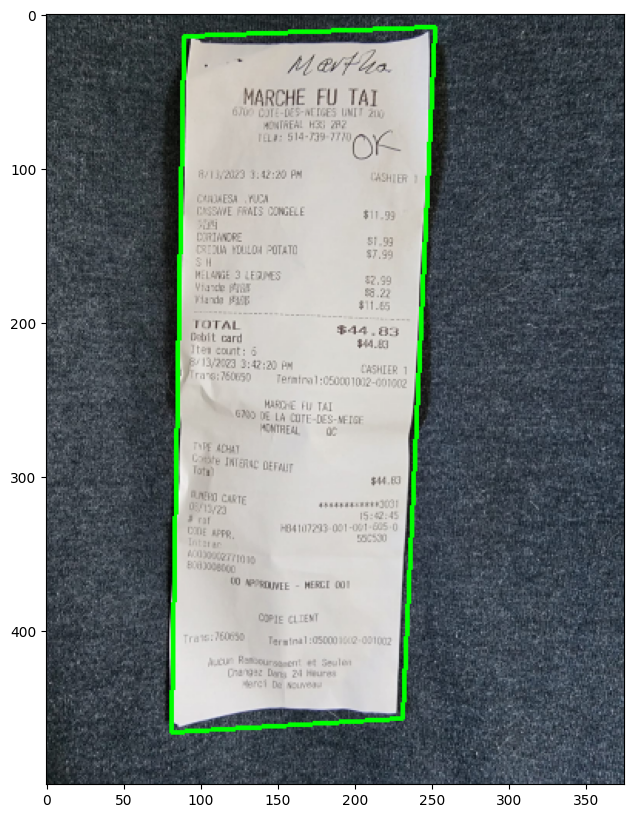

In [17]:
receipt_contour = get_receipt_contour(largest_contours)
image_with_receipt_contour = cv2.drawContours(image.copy(), [receipt_contour], -1, (0,255, 0), 2)
plot_rgb(image_with_receipt_contour)

In [18]:
def contour_to_rect(contour):
    pts = contour.reshape(4, 2)
    rect = np.zeros((4, 2), dtype = "float32")
    # top-left point has the smallest sum
    # bottom-right has the largest sum
    s = pts.sum(axis = 1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]
    # compute the difference between the points:
    # the top-right will have the minumum difference 
    # the bottom-left will have the maximum difference
    diff = np.diff(pts, axis = 1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]
    return rect / resize_ratio

In [19]:
def wrap_perspective(img, rect):
    # unpack rectangle points: top left, top right, bottom right, bottom left
    (tl, tr, br, bl) = rect
    # compute the width of the new image
    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    # compute the height of the new image
    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    # take the maximum of the width and height values to reach
    # our final dimensions
    maxWidth = max(int(widthA), int(widthB))
    maxHeight = max(int(heightA), int(heightB))
    # destination points which will be used to map the screen to a "scanned" view
    dst = np.array([
        [0, 0],
        [maxWidth - 1, 0],
        [maxWidth - 1, maxHeight - 1],
        [0, maxHeight - 1]], dtype = "float32")
    # calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(rect, dst)
    # warp the perspective to grab the screen
    return cv2.warpPerspective(img, M, (maxWidth, maxHeight))

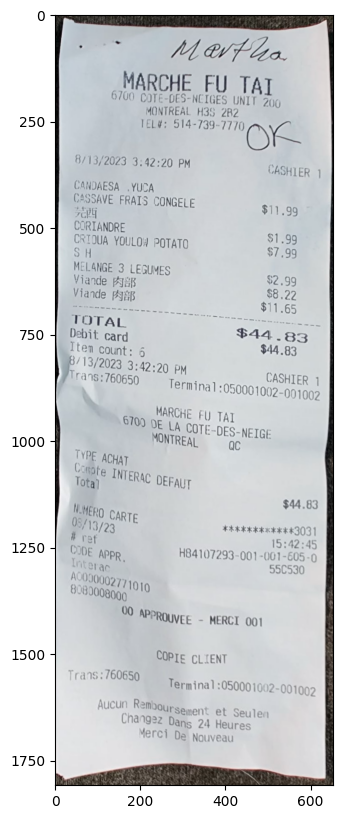

In [20]:
scanned = wrap_perspective(original.copy(), contour_to_rect(receipt_contour))
plt.figure(figsize=(16,10))
plt.imshow(scanned)

In [21]:
def bw_scanner(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    T = threshold_local(gray, 21, offset = 5, method = "gaussian")
    return (gray > T).astype("uint8") * 255

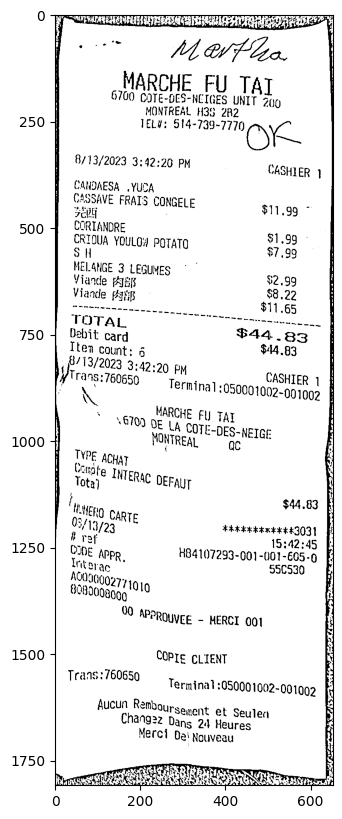

In [22]:
result = bw_scanner(scanned)
plot_gray(result)

In [23]:
output = Image.fromarray(result)
output.save('result.png')

In [24]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pytesseract
import re

from pytesseract import Output

In [25]:
def plot_gray(image):
    plt.figure(figsize=(16,10))
    return plt.imshow(image, cmap='Greys_r')

In [26]:
def plot_rgb(image):
    plt.figure(figsize=(16,10))
    return plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))


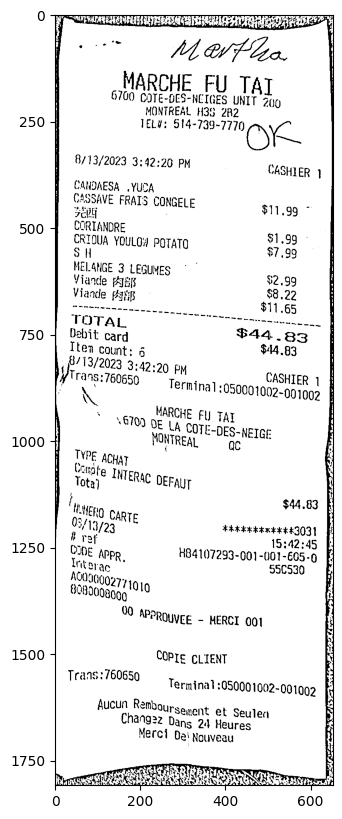

In [27]:
file_name = "result.png"
image = cv2.imread(file_name, cv2.IMREAD_GRAYSCALE) 
plot_gray(image)


pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'

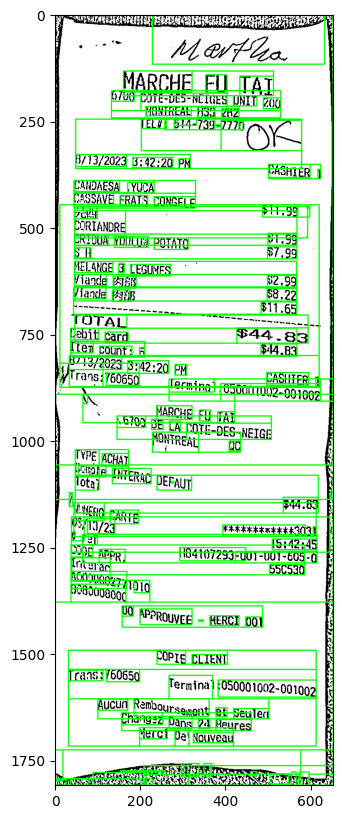

In [28]:
d = pytesseract.image_to_data(image, output_type=Output.DICT)
n_boxes = len(d['level'])
boxes = cv2.cvtColor(image.copy(), cv2.COLOR_BGR2RGB)
for i in range(n_boxes):
    (x, y, w, h) = (d['left'][i], d['top'][i], d['width'][i], d['height'][i])    
    boxes = cv2.rectangle(boxes, (x, y), (x + w, y + h), (0, 255, 0), 2)
    
plot_rgb(boxes)

In [29]:
extracted_text = pytesseract.image_to_string(image)
print(extracted_text)

MARCHE FU TAT

6700 COTE-OES-NEIGES UNIT 2090
MONTREAL H39 2A2

« §t4- ~ if
TELa: §14-739 me
8/13/2023 3:42:20 PM

CANDAESA .YUCA
CASSAVE FRAIS CONGELE

CASHIER 1

$11.99 -
Feng ;
CORTANDRE $1.99
CRIOUA YOUL! POTATO $7.99
SH
MELANGE 3 LEGUMES $2.99
Viande AYER $8.22
Viande pysy $11.65
TOTAL $44.83
Debit card $44.83
Tten count: ¢
8/13/2023 3:42:20 py CASHIER 1
trans: 760650

Terminal :050001002-001002

x MARCHE FU TAT
6709 DE LA COTE-DES-NETGE
MONTREAL ac
Nid ACHAT
1 Conte INTERAC DEF AL) \
Tota} DEFAUT $44.83
i
HERG CARTE UEKI T
pe lye3 19:42:45 |
raf -001-001-605-9
CODE Appa. H84107293-0 esceae
jitorac
AoddOGog79
8oBd00ggQ9 20

00 APPROUVEE — MERCY 001

Cope CLIENT
Trans: 760650 Terminal :050001002-001002
Aucun Remboursenent et Seulen
Chang2z Dang 24 Heures
Merci Da! Nouveau

LYRE D Pit ys Ly SEAR ae Cra ee
, HANA LRETSiokeniee
PRT ese: wy



In [30]:
def find_amounts(text):
    amounts = re.findall(r'\d+\.\d{2}\b', text)
    floats = [float(amount) for amount in amounts]
    floats
    unique = list(dict.fromkeys(floats))
    return unique

In [31]:
amounts = find_amounts(extracted_text)
amounts

[11.99, 1.99, 7.99, 2.99, 8.22, 11.65, 44.83]

In [32]:
pattern = "(\s+([A-Za-z0-9]+\s+)+)\$([+-])?"
items = re.findall(pattern,extracted_text)
items

[('\nCASSAVE FRAIS CONGELE\n\nCASHIER 1\n\n', '1\n\n', ''),
 ('\nCORTANDRE ', 'CORTANDRE ', ''),
 (' POTATO ', 'POTATO ', ''),
 ('\nSH\nMELANGE 3 LEGUMES ', 'LEGUMES ', ''),
 ('\nViande AYER ', 'AYER ', ''),
 ('\nViande pysy ', 'pysy ', ''),
 ('\nTOTAL ', 'TOTAL ', ''),
 ('\nDebit card ', 'card ', ''),
 (' DEFAUT ', 'DEFAUT ', '')]

In [34]:
pattern_amount = "([0-9]+\.[0-9]+)"
item_amount = re.findall(pattern_amount,extracted_text)
item_amount
# print("Price in line items:")
# print("====================")
# for row in extracted_text.split("\n"):
#     if re.search(pattern_amount,row) is not None:
#         print (row)

['11.99', '1.99', '7.99', '2.99', '8.22', '11.65', '44.83', '44.83', '44.83']